# Travel Package Purchase Prediction

Prepared by: Jaime Lopez  
Date: July 2022

"Visit with us" is planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being. The company wants to harness the available data of existing and potential customers to target the right customers. In this notebook, we analyze the customers' data and information to provide recommendations to the Policy Maker and build a model to predict the potential customer who is going to purchase the newly introduced travel package. The model will be built to make predictions before a customer is contacted. 

**Objective**

To predict which customer is more likely to purchase the newly introduced travel package.

**Data Dictionary**

Customer details:

* CustomerID: Unique customer ID
* ProdTaken: Whether the customer has purchased a package or not (0: No, 1: Yes)
* Age: Age of customer
* TypeofContact: How customer was contacted (Company Invited or Self Inquiry)
* CityTier: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3. It's the city the customer lives in.
* Occupation: Occupation of customer
* Gender: Gender of customer
* NumberOfPersonVisiting: Total number of persons planning to take the trip with the customer
* PreferredPropertyStar: Preferred hotel property rating by customer
* MaritalStatus: Marital status of customer
* NumberOfTrips: Average number of trips in a year by customer
* Passport: The customer has a passport or not (0: No, 1: Yes)
* OwnCar: Whether the customers own a car or not (0: No, 1: Yes)
* NumberOfChildrenVisiting: Total number of children with age less than 5 planning to take the trip with the customer
* Designation: Designation of the customer in the current organization
* MonthlyIncome: Gross monthly income of the customer

Customer interaction data: 

* PitchSatisfactionScore: Sales pitch satisfaction score
* ProductPitched: Product pitched by the salesperson
* NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
* DurationOfPitch: Duration of the pitch by a salesperson to the customer

## Environment setting

In this section liberies and data are loaded into memory.

A sample view of the dataset is shown to have a sense what information it contains.

In [50]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt     # Basic plotting functions
import pandas as pd                 # Dataframe manipulation
import seaborn as sns               # Statistical plotting
from sklearn.model_selection\
    import train_test_split, GridSearchCV
from sklearn.metrics\
    import confusion_matrix, make_scorer, recall_score
from sklearn.ensemble\
    import BaggingClassifier, RandomForestClassifier,\
           AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

SEED = 1                            # Default Random State

# Loading dataset
data = pd.read_excel("Tourism.xlsx", sheet_name="Tourism")
# A random sample
data.sample(10, random_state=SEED)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
3015,203015,0,27.0,Company Invited,1,7.0,Salaried,Female,4,6.0,Basic,3.0,Married,5.0,0,4,1,3.0,Executive,23042.0
1242,201242,0,40.0,Self Enquiry,3,13.0,Small Business,Male,2,3.0,King,4.0,Single,2.0,0,4,1,NaN,VP,34833.0
3073,203073,0,29.0,Self Enquiry,2,15.0,Small Business,Male,4,5.0,Basic,3.0,Married,3.0,0,2,0,2.0,Executive,23614.0
804,200804,0,48.0,Company Invited,1,6.0,Small Business,Male,2,1.0,Super Deluxe,3.0,Single,3.0,0,2,0,0.0,AVP,31885.0
3339,203339,0,32.0,Self Enquiry,1,18.0,Small Business,Male,4,4.0,Deluxe,5.0,Divorced,3.0,1,2,0,3.0,Manager,25511.0
3080,203080,1,36.0,Company Invited,1,32.0,Salaried,Female,4,4.0,Basic,4.0,Married,3.0,1,3,0,1.0,Executive,20700.0
2851,202851,0,46.0,Self Enquiry,1,17.0,Salaried,Male,4,4.0,Basic,3.0,Divorced,5.0,0,5,1,1.0,Executive,21332.0
2883,202883,1,32.0,Company Invited,1,27.0,Salaried,Male,4,4.0,Standard,3.0,Divorced,5.0,0,3,1,1.0,Senior Manager,28502.0
1676,201676,0,22.0,Self Enquiry,1,11.0,Salaried,Male,2,1.0,Basic,4.0,Married,2.0,1,4,1,0.0,Executive,17328.0
1140,201140,0,44.0,Self Enquiry,1,13.0,Small Business,Female,2,3.0,King,3.0,Married,1.0,1,4,1,1.0,VP,34049.0


## Exploratory data analysis I

In this section, a first take of exploratory data analysis is made.
It focus in univariate analysis to know what data is representating and how is distributed.

### Setting for the exploratory analysis

Some functions to support the univariate analysis are defined:

* `showFreqValues`: to analize categorical and discrete values
* `missedValues`: to show the percentage of missed values in a feature
* `showContinuousFreq`: to analize continuous values

In [23]:
def showFreqValues(data, feature):
    """
    To visualizing distribution for
    discrete or categorical features
    """
    counts = data[feature].value_counts().sort_index()
    sum_counts = counts.sum()
    rel_counts = counts / sum_counts 
    ax = rel_counts.plot(kind='bar', title=feature,
              ylabel="Relative frequency", xlabel="Values")
    for i, v in enumerate(counts):
        ax.text(i - 0.05, v / sum_counts + 0.02, str(v))
    # plt.ylim(0.0, 1.0)
    plt.show()
    missedValues(data, feature)
    # return counts
    
def missedValues(data, feature):
    """
    To compute the proportion of missed values
    """
    p = data[feature].isna().sum() / len(data)
    print("Percentage of missed values for {0:}: {1:.2%}".format(feature, p))
    return p

def showContinuousFreq(data, feature):
    """
    To visualize the distribution of a continuous numerical feature
    """
    fig, ax = plt.subplots(nrows=2)
    sns.boxplot(data=data, x=feature, ax=ax[0])
    sns.histplot(data=data, x=feature, ax=ax[1])
    ax[0].set_title(feature)
    plt.show()
    print(data[feature].describe(), "\n")
    missedValues(data, feature)

### Dataset characteristics

In this section, global characteristics of the dataset are shown.

In [13]:
## Dataset dimensions
print("Dataset dimensions:")
print("  Number of observations: ", data.shape[0])
print("  Number of features    : ", data.shape[1])

Dataset dimensions:
  Number of observations:  4888
  Number of features    :  20


In [14]:
## Looking for duplicates
print("Number of duplicated records: ", data.duplicated().sum() / 2) 

Number of duplicated records:  0.0


In [15]:
# Checking the feature names
print("Feature names:")
data.columns

Feature names:


Index(['CustomerID', 'ProdTaken', 'Age', 'TypeofContact', 'CityTier',
       'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar',
       'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
       'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [16]:
# Feature basic information
print("Feature basic information:")
data.info()

Feature basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-n

### Univariate Analysis

For each feature, a visualization about the data distribution is shown and some comments are included.

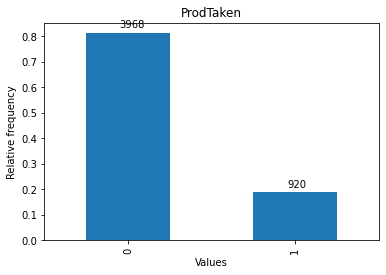

Percentage of missed values for ProdTaken: 0.00%


In [17]:
counts = showFreqValues(data, "ProdTaken")

* `ProdTaken` is the target feature
* `1` represents that the customer has purchased a package
* Around 20 % of customers have taken a package
* This feature has not missed values

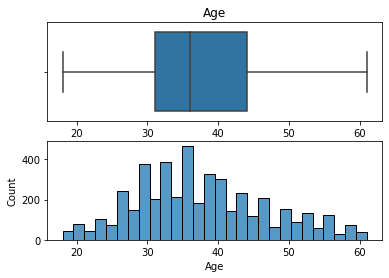

count    4662.000000
mean       37.622265
std         9.316387
min        18.000000
25%        31.000000
50%        36.000000
75%        44.000000
max        61.000000
Name: Age, dtype: float64 

Percentage of missed values for Age: 4.62%


In [24]:
showContinuousFreq(data, 'Age')

* `Age` has a centered distribution.  
* It ranges from 18 to 61 years old, with a median of 37 years old
* It has 4.62 % of missed values with can be attributed using the median

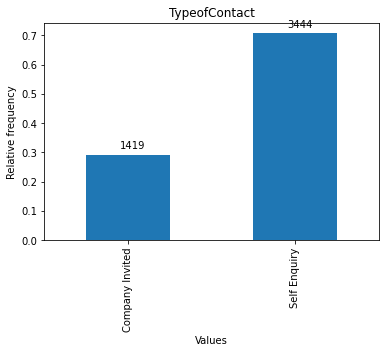

Percentage of missed values for TypeofContact: 0.51%


In [25]:
showFreqValues(data, 'TypeofContact')

* `TypeofContact` has around 70 % of customer by self enquiry and around 30 % invited by the company
* This feature has 0.51 % of missed values
* Missed values can be attributed randomly using the mode

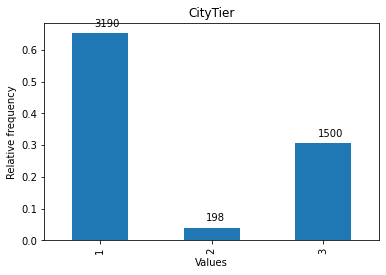

Percentage of missed values for CityTier: 0.00%


In [26]:
showFreqValues(data, "CityTier")

* The most of the customers live in Tier 1 (around 65%)
* `CityTier` has not missed values

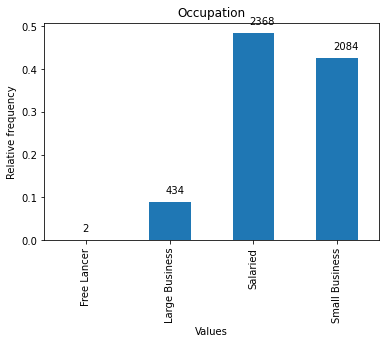

Percentage of missed values for Occupation: 0.00%


In [27]:
showFreqValues(data, "Occupation")

* The most of customers are salaried and small business owners (around 90%)
* `Occupation` has not missed values

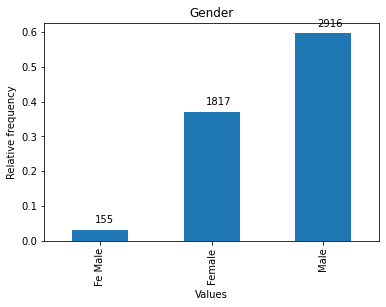

Percentage of missed values for Gender: 0.00%


In [28]:
showFreqValues(data, "Gender")

* The most of the customers are male (around 60%)
* The are observations with female gender that are wrong coded; this should be fixed

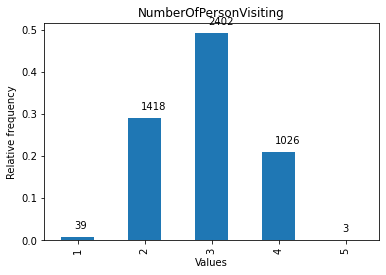

Percentage of missed values for NumberOfPersonVisiting: 0.00%


In [29]:
showFreqValues(data, "NumberOfPersonVisiting")

* The group size that can take the trip is mostly of 3 person (around 50%)
* `NumberOfPersonVisiting` has not missed values

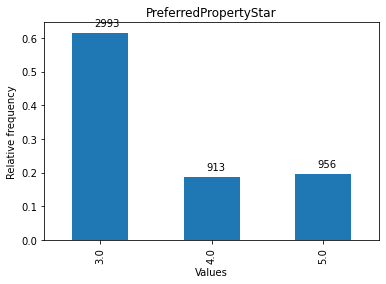

Percentage of missed values for PreferredPropertyStar: 0.53%


In [30]:
showFreqValues(data, "PreferredPropertyStar")

* Around 60% of customers prefered a 3 star hotel
* `PreferredPropertyStar` has 0.53% missed values
* Missed values can be attributed using the mode

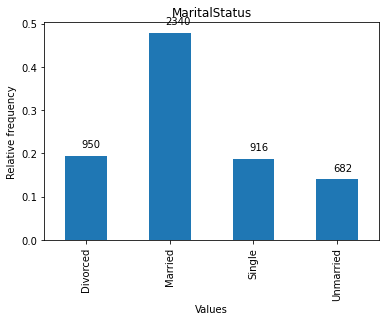

Percentage of missed values for MaritalStatus: 0.00%


In [31]:
showFreqValues(data, "MaritalStatus")

* Around 50% of customers are married
* `MaritalStatus` feature has not missed values

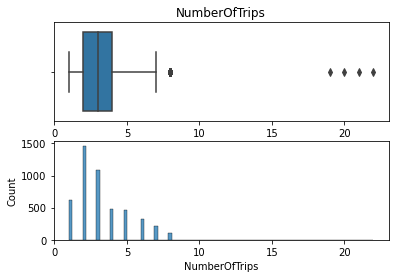

count    4748.000000
mean        3.236521
std         1.849019
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        22.000000
Name: NumberOfTrips, dtype: float64 

Percentage of missed values for NumberOfTrips: 2.86%


In [32]:
showContinuousFreq(data, "NumberOfTrips")

* The most of customers take between 2 and 3 trips a year (above 50%)
* Customers with more than 8 trips can be considered outliers
* `NumberOfTrips` has 2.86% of missed values
* Missed values can be attributed with the median

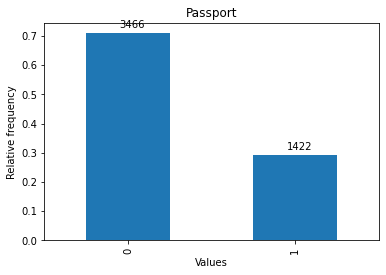

Percentage of missed values for Passport: 0.00%


In [33]:
showFreqValues(data, "Passport")

* Around 70% of customers have passport
* `Passport` feature does not have missed values

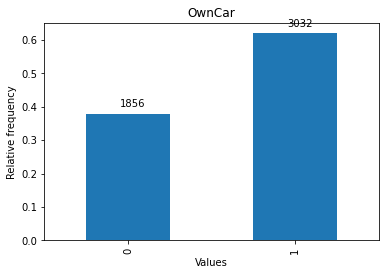

Percentage of missed values for OwnCar: 0.00%


In [34]:
showFreqValues(data, "OwnCar")

* The most of the customers own a car (above 60%)
* `OwnCar` feature has not missed values

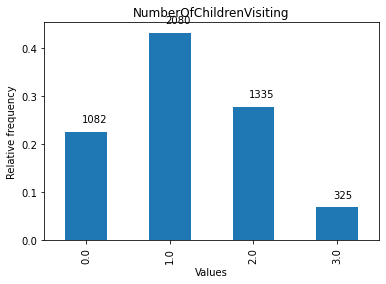

Percentage of missed values for NumberOfChildrenVisiting: 1.35%


In [35]:
showFreqValues(data, "NumberOfChildrenVisiting")

* The most of customers has 1 children visiting (above 40%)
* `NumberOfChildrenVisiting` feature has 1.35% of missed values
* Missed values can be attributed using the median

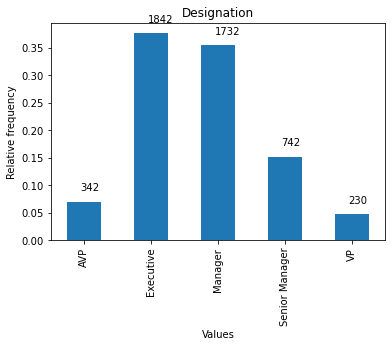

Percentage of missed values for Designation: 0.00%


In [36]:
showFreqValues(data, "Designation")

* Above 70% of customer are executives and managers
* `Designation` feature has not missed values

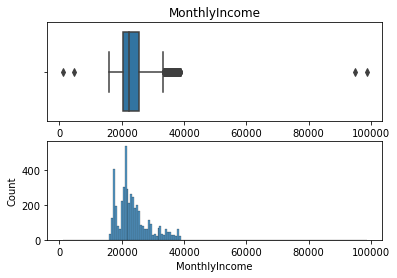

count     4655.000000
mean     23619.853491
std       5380.698361
min       1000.000000
25%      20346.000000
50%      22347.000000
75%      25571.000000
max      98678.000000
Name: MonthlyIncome, dtype: float64 

Percentage of missed values for MonthlyIncome: 4.77%


In [37]:
showContinuousFreq(data, "MonthlyIncome")

* Around 50% of customers has income between 20.3 USD thousand and 25.5 USD thousand
* `MonthlyIncome` feature has 4.77% of missed values
* Missed values can be attributed using the median

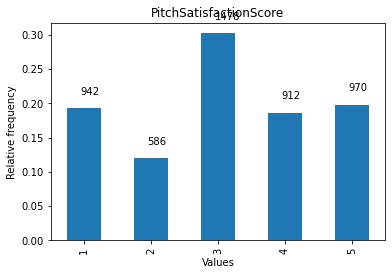

Percentage of missed values for PitchSatisfactionScore: 0.00%


In [38]:
showFreqValues(data, 'PitchSatisfactionScore')

* The most of the customers assigned 3 as the pitch satisfaction score
* `PitchSatisfactionScore` feature has not missed values

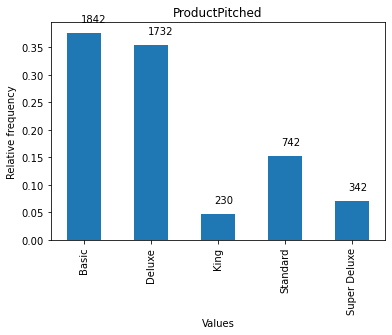

Percentage of missed values for ProductPitched: 0.00%


In [39]:
showFreqValues(data, 'ProductPitched')

* Above 35% of customers was pitched for the basic product; the same for the deluxe product
* `ProductPitched` feature has not missed values

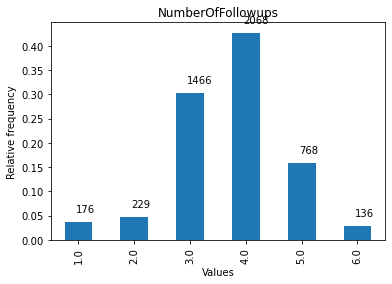

Percentage of missed values for NumberOfFollowups: 0.92%


In [40]:
showFreqValues(data, 'NumberOfFollowups')

* The most of the customers requires up to 4 follow ups (above 40%)
* `NumberOfFollowups` has 0.92% of missed values
* Missed values can be attributed using the median

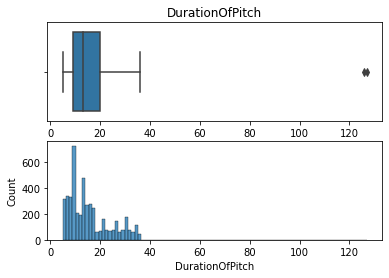

count    4637.000000
mean       15.490835
std         8.519643
min         5.000000
25%         9.000000
50%        13.000000
75%        20.000000
max       127.000000
Name: DurationOfPitch, dtype: float64 

Percentage of missed values for DurationOfPitch: 5.14%


In [41]:
showContinuousFreq(data, 'DurationOfPitch')

* It is assumed that duration of pitch is measured in minutes
* Around 50% of customers got a pitch between 9 and 20 minutes
* There are long pitch duration, like a maximum of 127 minutes
* `DurationOfPitch` has 5.14% of missed values
* Missed values can be attributed using the median

**Comments from the univariate analysis:**

* The dataset has 4888 observations with 20 features, without duplicated observations
* The most of the customers:
    * live in Tier 1 sectors
    * are salaried or small business owners
    * are executives or managers (above 70%)
    * own a car (above 60%)
    * males (above 60%) and married (above 45%)
    * have passport (above 70%)
    * three person in their visiting group, with one children
    * prefer a three star hotel
    * have taken between 2 and 3 trips a year (above 50%)
* Age customers ranges from 18 to 61 years old, with a median of 37 years old
* Above 50% of customers have an income between 20.3 y 25.5 USD thounsand
* Around 70% of customers have been contacted by self inquiry
* The most of the customers assigned 3 as the pitch satisfaction score
* Above 35% of customers was pitched for the basic product; the same percentage for the deluxe product
* The most of the customers requires up to 4 follow ups (above 40%)
* Around 50% of customers got a pitch between 9 and 20 minutes
* Around 20 % of customers have taken a package



## Data pre-processing I

In this section some transformation on data are made, specifically:

* `CustomerID` is an identification feature; it will be used as the dataset index
* `Age`, `NumberOfTrips`, `NumberOfChildrenVisiting`, `MonthlyIncome`, `NumberOfFollowups`, and `PreferredPropertyStar`, and `DurationOfPitch` missed values will be attributed using the median
* `TypeofContact` missed values will be attributed using the mode
* In the `Gender` feature, `Fe Male` value should be replaced by `Female`

In [51]:
# Using CustomerID as index
data.set_index('CustomerID', inplace=True)

# Fixing gender values
data['Gender'].replace('Fe Male', 'Female', inplace=True)
data['Gender'].value_counts()

# Filling missed values with median
cols = [
    "Age", "NumberOfTrips", "NumberOfChildrenVisiting", 
    "MonthlyIncome", "NumberOfFollowups", "DurationOfPitch",
    "PreferredPropertyStar"
]
data[cols] = data[cols].fillna(data[cols].median())

# Filling missed values with mode
col = "TypeofContact"
data[col] = data[col].fillna(data[col].mode()[0])

# Checking if there are still missed values
print("Missed data: ")
data.isna().sum()

ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

Missed data has been attributed. No more missed data is remaining.

## Exploratory data analysis II

In this section a bivariate analysis is taken.

### Preliminary feature importance

In this section the relationship among features respect the target feature will be analized.

For categorical and discrete values, the criteria of information gain will be used:

$$\text{Gain}(T, F) = H(T) - H(T, F) = H(T) - \sum_{i=0}^{n} \frac{T_i}{T} H(T_i)$$

Where:

* $H(T)$: Entropy of all the target feature
* $H(T, F)$: Entropy after partitioning the target by a feature $F$

For continuous features, correlation is used as a measure of feature importance.

In [53]:
# Setting the target feature
target = "ProdTaken"

def entropy(values):
    """
    To compute the entropy of a vector
    """
    p = values.value_counts() / len(values)
    accum = 0
    for el in p:
        accum -= el * np.log(el)
    return accum

def gain(data, feature, target):
    """
    To compute the information gain based on entropy
    after a class has been partitioned by a feature
    """
    e = entropy(data[target])
    n = len(data[feature])
    for value in data[feature].unique():
        rs = data[data[feature] == value][target]
        prop = len(rs) / n
        e -= prop * entropy(rs)
    return e

# Categorical and discrete features
noncontinuos = [col for col in data.columns if data[col].dtype in ['int64', 'object'] and col != target]
# Continuous featrues
continuous = list(set(data.columns).difference(set(noncontinuos)))

**Information gain for categorical and discrete value features**

<AxesSubplot:title={'center':'Information Gains related to ProdTaken'}, xlabel='feature', ylabel='Information Gain'>

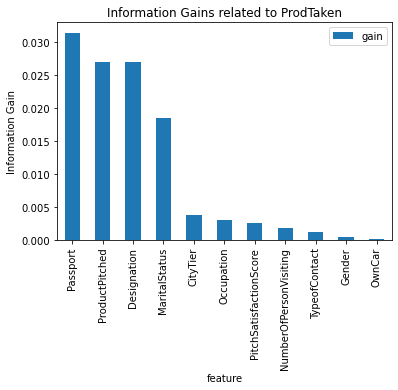

In [57]:
gains = pd.DataFrame(
    [
        {'feature': col, 'gain': gain(data, col, target)} 
        for col in noncontinuos
    ]
)\
    .set_index('feature')\
    .sort_values(by='gain', ascending=False)
gains.plot(
    kind='bar', 
    ylabel="Information Gain", 
    title=f"Information Gains related to {target}"
)

**Correlations for continuous value features**

<AxesSubplot:title={'center':'Correlations related to ProdTaken'}, ylabel='Absolute correlation'>

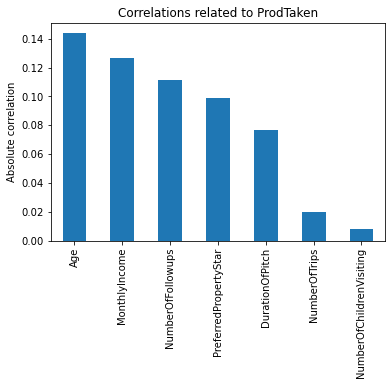

In [58]:
corrs = data[continuous]\
    .corr()[target]\
    .abs()\
    .drop(target)\
    .sort_values(ascending=False)
corrs.plot(
    kind='bar', 
    ylabel="Absolute correlation", 
    title=f"Correlations related to {target}"
)

### Exploring the most preliminary important features

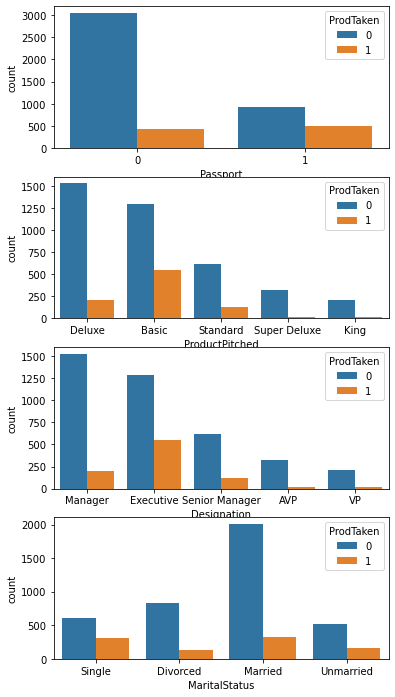

In [74]:
features = ["Passport", "ProductPitched", "Designation", "MaritalStatus"]
n = len(features)
fig, ax = plt.subplots(nrows=n, figsize=(6, n * 3))
for i, feature in enumerate(features):
    sns.countplot(data=data, x=feature, hue="ProdTaken", ax=ax[i])

For categorical and discrete value features:

* Customers that have passport are more proned to take the product
* Customers that are executives are more proned to take the product
* Customers that get the basic product pitched are more proned to take it

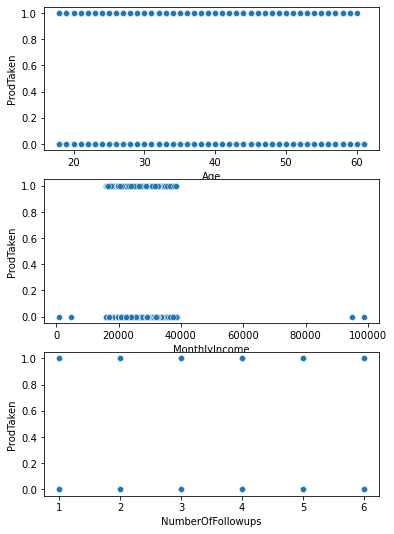

In [76]:
features = ["Age", "MonthlyIncome", "NumberOfFollowups"]
n = len(features)
fig, ax = plt.subplots(nrows=n, figsize=(6, n * 3))
for i, feature in enumerate(features):
    sns.scatterplot(data=data, x=feature, y="ProdTaken", ax=ax[i])

For continuous value features, it doesn't seen to be a noted partition in data.

## Evaluation setting

In this section criteria to evaluate the prediction models are defined.

* For each model, a confussion matrix will be computed, indicaticating the perfomance for true positive (TP), false positive (FP), true negative (TN), and false negative (FN) results.
* For each model, based in its confussion matrix computed on the test dataset, indicators of accuracy, precision, recall, specificity will be generated.
* Due the analysis function is to support the taking of travel packages, false negatives have more cost that false possives. The company can loss income if the false negatives are not reached.
* Based on the previous point, recall indicator will prioritized as measument of model goodness
* A class is defined to store metrics for the different models that will be generated

In [89]:
def computeMetrics(y_test, y_predicted):
    """
    Compute performance indicators for predictive
    classification models
    """
    cf = confusion_matrix(y_test, y_predicted, labels=[1, 0])
    TP = cf[0, 0]
    FP = cf[0, 1]
    FN = cf[1, 0]
    TN = cf[1, 1]
    precission = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precission * recall / (precission + recall)
    return {
        'cf': cf,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'accuracy': (TP + TN) / cf.sum(),
        'precission': precission,
        'recall': recall,
        'specifity': TN / (TN + FP),
        'f1': f1
    }

def showMetrics(metrics):
    """
    Plot the most relevant metrics for
    a predictive classification model
    """
    indLabels = ['accuracy', 'precission', 'recall', 'specifity', 'f1']
    cf = metrics['cf']
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    annot = [['{0:0.0f}\n'.format(value) + '{0:0.2%}'.format(value / cf.sum()) for value in row] for row in cf]
    sns.heatmap(cf, annot=annot, fmt='', cmap='Spectral', vmin=0, cbar=False, ax=ax[0])
    ax[0].set_ylabel('Observed')
    ax[0].set_xlabel('Prediced')
    ind = {label: metrics[label] for label in indLabels}
    ax[1].bar(ind.keys(), ind.values())
    ax[1].set_xlabel('Classification Metrics')
    for label in indLabels:
        print('{0:10}: {1:0.3}'.format(label, metrics[label]))
        
def featureImportance(model, colnames):
    """
    To visualize the importante of features given by a model
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [colnames[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
# A array is defined to store the different models generated
class MetricsComparator:
    """
    A class to store and compare different models
    """
    metrics_collection = []
    def __init__(self):
        self.metrics_collection = []
    def append(self, code, model, metrics, label):
        metrics['code'] = code
        metrics['label'] = label
        metrics['model'] = model
        self.metrics_collection.append(metrics.copy())
    def compare(self, modelList=None):
        """
        Compare metrics for the collection of models
        """
        coll = self.metrics_collection.copy()
        if modelList:
            coll = [m for m in self.metrics_collection if m['code'] in modelList]
        indLabels = ['accuracy', 'precission', 'recall', 'specifity', 'f1']
        comp = pd.DataFrame(coll)[indLabels + ['label']]
        comp.set_index('label', inplace=True)
        comp.plot(kind='bar', figsize=(16, 8))
        return comp
    
# Class instance
mc = MetricsComparator()

## Data pre-processing II

This is the continuation of the data pre-processing task. Here:

* Categorical data is convert to dummy features
* Dataset is divided in X features and the target feature
* Train and test samples are generated

In [82]:
# Generating dummy features
print("Dataset with dummy features:\n")
columns = ["TypeofContact", "Occupation", "Gender", "ProductPitched", "MaritalStatus", "Designation"]
df = pd.get_dummies(data, columns=columns, drop_first=True)
df.info()

Dataset with dummy features:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4888 entries, 200000 to 204887
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ProdTaken                    4888 non-null   int64  
 1   Age                          4888 non-null   float64
 2   CityTier                     4888 non-null   int64  
 3   DurationOfPitch              4888 non-null   float64
 4   NumberOfPersonVisiting       4888 non-null   int64  
 5   NumberOfFollowups            4888 non-null   float64
 6   PreferredPropertyStar        4888 non-null   float64
 7   NumberOfTrips                4888 non-null   float64
 8   Passport                     4888 non-null   int64  
 9   PitchSatisfactionScore       4888 non-null   int64  
 10  OwnCar                       4888 non-null   int64  
 11  NumberOfChildrenVisiting     4888 non-null   float64
 12  MonthlyIncome                4888 non-n

In [83]:
# Generating X and y datasets
target = "ProdTaken"
X = df.drop(columns=target)
y = df[target]

# Spliting train and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=SEED, 
    stratify=y
)

In [84]:
print("X train sample dimensions: ", X_train.shape)
print("X test sample dimensions : ", X_test.shape)
print()
print("y train class proportions:\n{}\n".format(y_train.value_counts() / len(y_train)))
print("y test class proportions :\n{}\n".format(y_train.value_counts() / len(y_train)))

X train sample dimensions:  (3421, 28)
X test sample dimensions :  (1467, 28)

y train class proportions:
0    0.811751
1    0.188249
Name: ProdTaken, dtype: float64

y test class proportions :
0    0.811751
1    0.188249
Name: ProdTaken, dtype: float64



## Modeling: basic classifiers

To have a starting reference, in this section two basic models are genereted:

* Decission Tree Classifier
* Logistic Regression Classifier

Both of then are processed with default parameters.

These models will be used to compare performance for bagging and boosting models.

### Decision Tree Classifier

Depth :  20
Leaves:  392
accuracy  : 0.878
precission: 0.674
recall    : 0.676
specifity : 0.924
f1        : 0.675


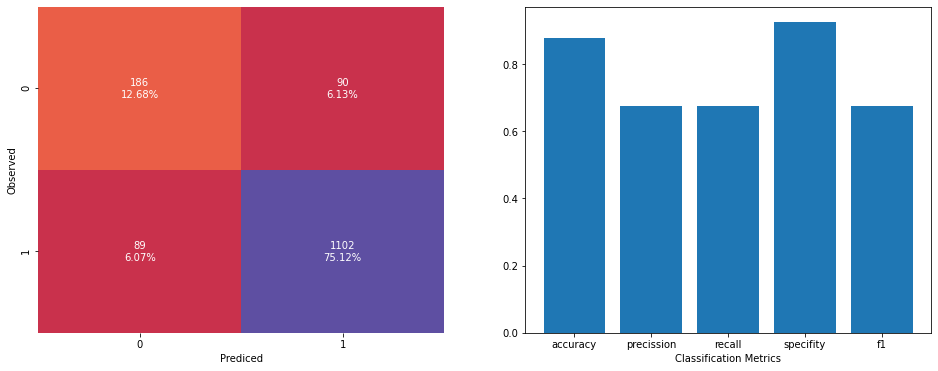

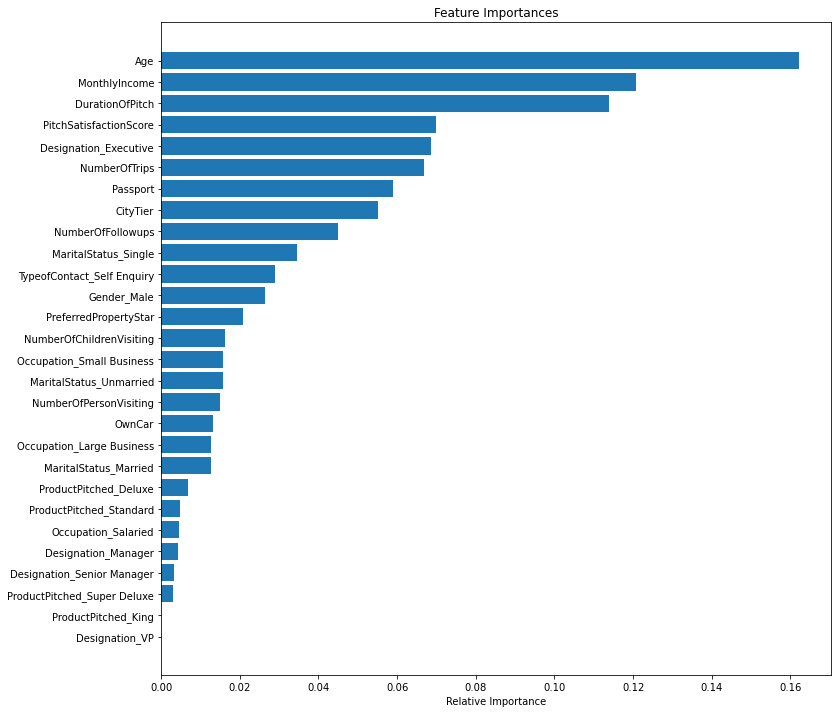

In [90]:
model = DecisionTreeClassifier(random_state=SEED)
model.fit(X_train, y_train)

print("Depth : ", model.get_depth())
print("Leaves: ", model.get_n_leaves())

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("DTC", model, metrics, "Decision Tree")

Using the test sample and related to the recall score, this decision tree classifier has a performance of 0.676.

### Logistic Regression

accuracy  : 0.825
precission: 0.101
recall    : 0.757
specifity : 0.827
f1        : 0.179


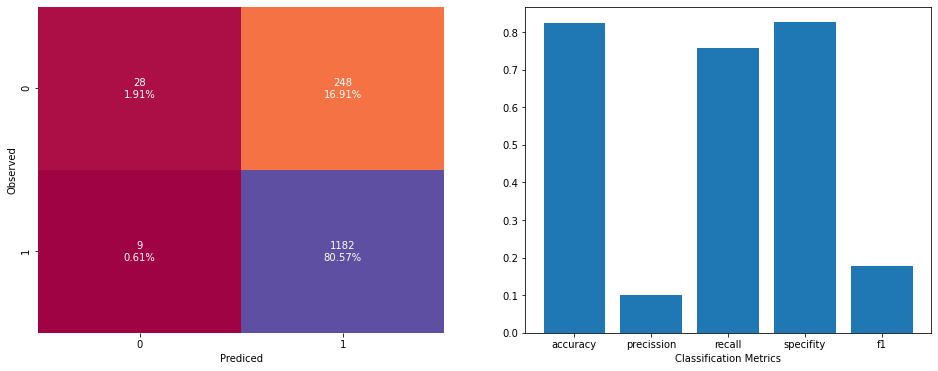

In [91]:
model = LogisticRegression(random_state=SEED)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)

mc.append("LRC", model, metrics, "Logistic Regression")

### Model comparison

,accuracy,precission,recall,specifity,f1
label,,,,,
Decision Tree,0.877982,0.673913,0.676364,0.924497,0.675136
Logistic Regression,0.824813,0.101449,0.756757,0.826573,0.178914


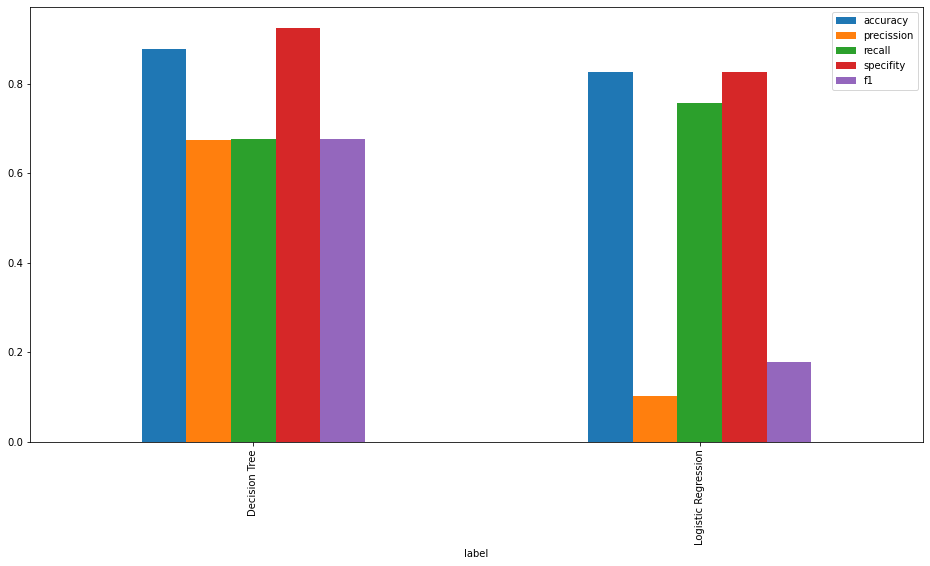

In [92]:
mc.compare(['DTC', 'LRC'])

The logistic regression model has a better performance on the test sample, related to the decision tree classifier, with a recall score of 0.757. Based on that, this basic model will be used as performance comparison against bagging and boosting models.

## Modelling: Bagging

In this section bagging algorithms with default parameters are used to try to improve the prediction performance on data.

### Baggin Classifier

accuracy  : 0.91
precission: 0.609
recall    : 0.875
specifity : 0.915
f1        : 0.718


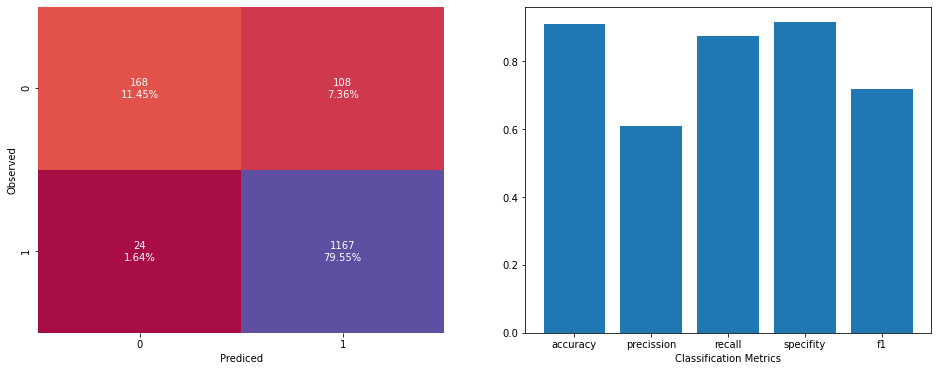

In [93]:
model = BaggingClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)

mc.append("BAG", model, metrics, "Default Bagging")

### Random Forest Classifier

accuracy  : 0.916
precission: 0.591
recall    : 0.942
specifity : 0.913
f1        : 0.726


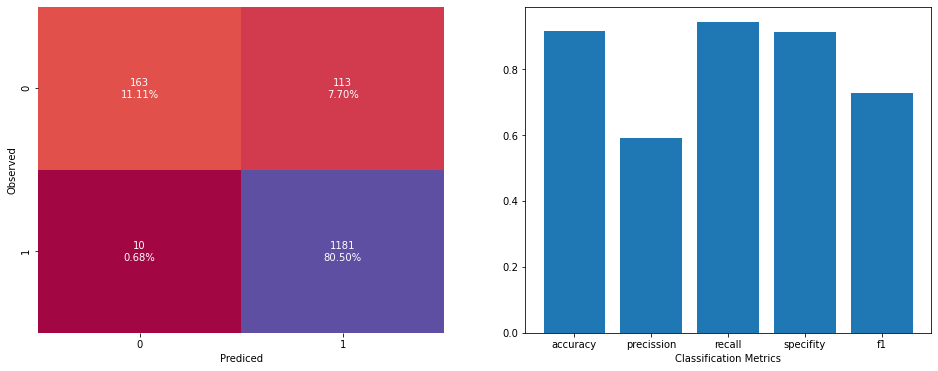

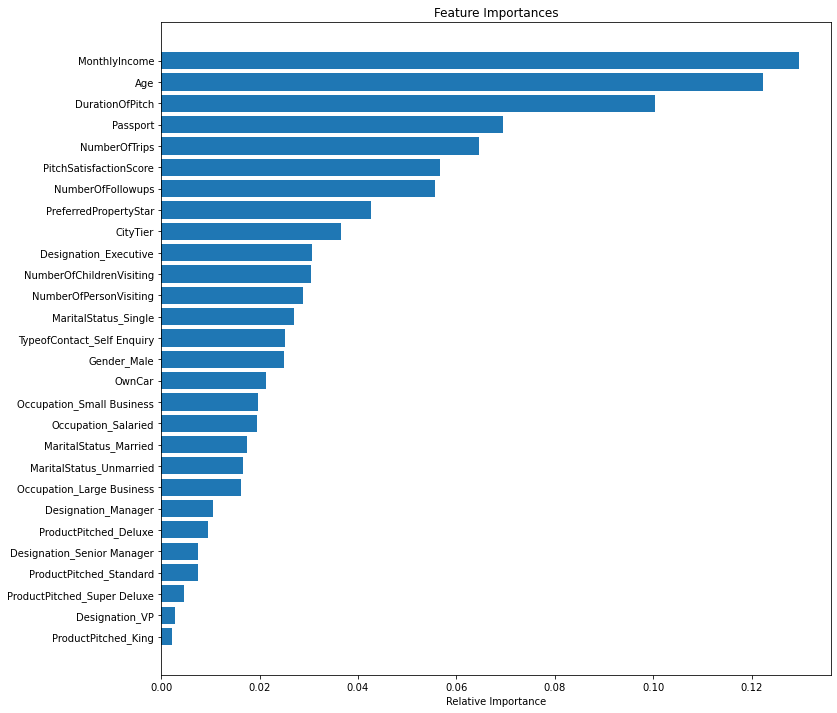

In [94]:
model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("RFC", model, metrics, "Random Forest")

### Model comparison

,accuracy,precission,recall,specifity,f1
label,,,,,
Logistic Regression,0.824813,0.101449,0.756757,0.826573,0.178914
Default Bagging,0.910020,0.608696,0.875000,0.915294,0.717949
Random Forest,0.916155,0.590580,0.942197,0.912674,0.726058


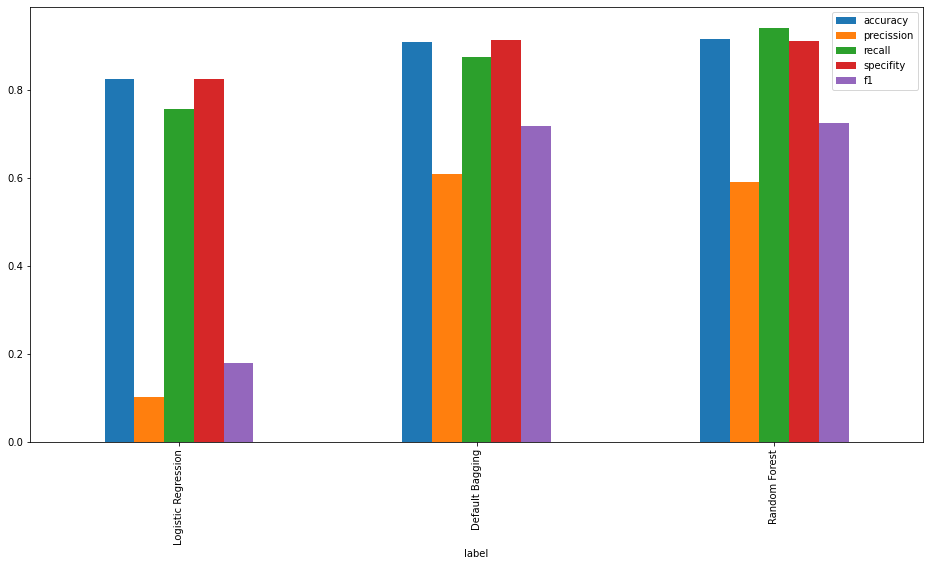

In [95]:
mc.compare(["LRC", "BAG", "RFC"])

* Both, Bagging and Random Forest classifiers shown an improved perfomance related to the basic models, i.e. Logistic Regression, when they are compared based on the recall score computed on the test sample
* Random Forest Classifier has a better performance, with a recall score of 0.92
* According to the Random Forest Classifier, the most important features are Monthly Income, Age, and Duration of Pitch

## Modelling: Bagging with Hyper-parameter tunning

In this section, Bagging and Random Forest classifiers are optimized with hyper-parameter tunning to check if a improvement can be obtained.

### Bagging Classifier

* Base estimator is tried between Decision Tree and Logistic Regression classifiers
* Number of estimators are evaluated between 10 and 100
* Maximum of samples is evaluated between 0.7 y 1.0
* Maximum of features is evaluated between 0.7 and 1.0
* Recall score is used as scoring parameter

In [96]:
base_model = BaggingClassifier(random_state=SEED)
parameters = {
    "base_estimator": [DecisionTreeClassifier(random_state=SEED), LogisticRegression(random_state=SEED)],
    "n_estimators": np.arange(10, 100, 10),
    "max_samples": np.arange(0.7, 1.0, 0.1),
    "max_features": np.arange(0.7, 1.0, 0.1),
}
scorer = make_scorer(recall_score)
gs = GridSearchCV(base_model, parameters, scoring=scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
model = gs.best_estimator_
model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                  max_features=0.9999999999999999,
                  max_samples=0.9999999999999999, n_estimators=80,
                  random_state=1)

The best model has as parameters:
    
* The decision tree classifier
* 80 estimators
* 100% of features
* 100% of samples

accuracy  : 0.928
precission: 0.67
recall    : 0.925
specifity : 0.928
f1        : 0.777


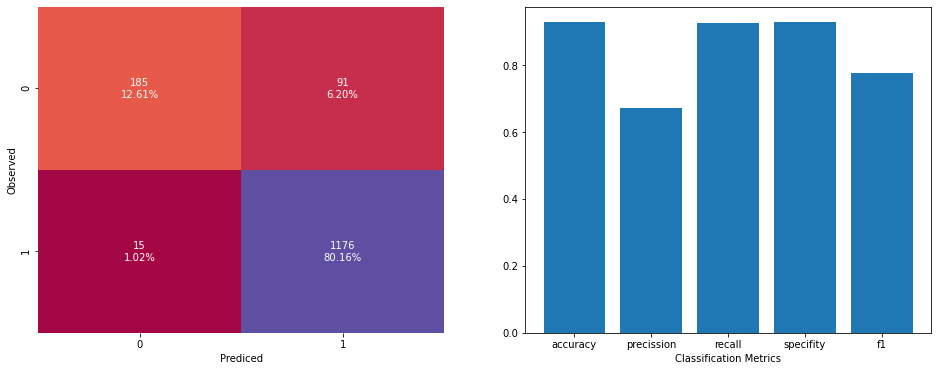

In [98]:
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)

mc.append("HBC", model, metrics, "Hyp-Tunned Bagging Classifier")

The hyper-parameter tunning on the Bagging Classifier has improved the recall performance.

### Random Forest

* The model is tunned between 10 and 100 estimators
* Maximum depth is evaluated between 2 y 20 levels
* Maximum features is evaluated between 0.5 and 1.0
* Maximum samples is evaluated between 0.5 and 1.0
* Class weights are alternated between 0.5/0.5 and 0.3/0.7

In [101]:
base_model = RandomForestClassifier(random_state=SEED)
parameters = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": np.arange(2, 20, 1),
    "max_features": np.arange(0.5, 1.0, 0.1),
    "max_samples": np.arange(0.5, 1.0, 0.1),
    "class_weight": [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7}],
}
scorer = make_scorer(recall_score)
gs = GridSearchCV(base_model, parameters, scoring=scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
model = gs.best_estimator_
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5, 1: 0.5}, max_depth=19,
                       max_features=0.7999999999999999,
                       max_samples=0.8999999999999999, n_estimators=80,
                       random_state=1)

The best model has as parameters:

* Class weights: 0.5/0.5
* Maximum depth: 19 levels
* Maximum features: 0.8
* Maximum samples: 0.9
* Number of estimators: 80

accuracy  : 0.928
precission: 0.663
recall    : 0.938
specifity : 0.927
f1        : 0.777


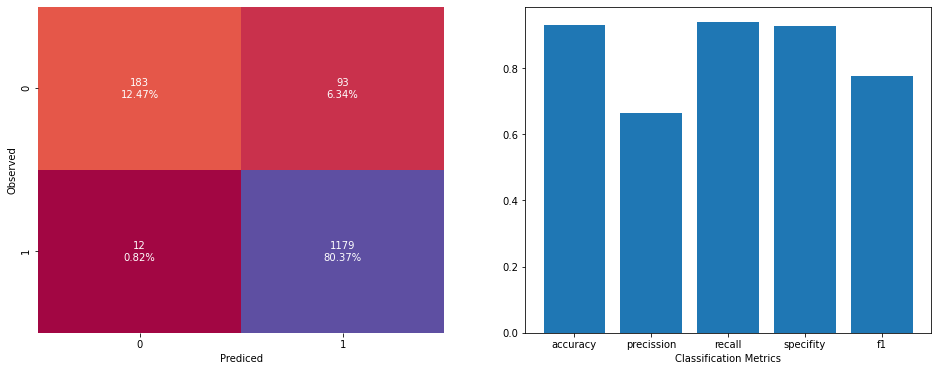

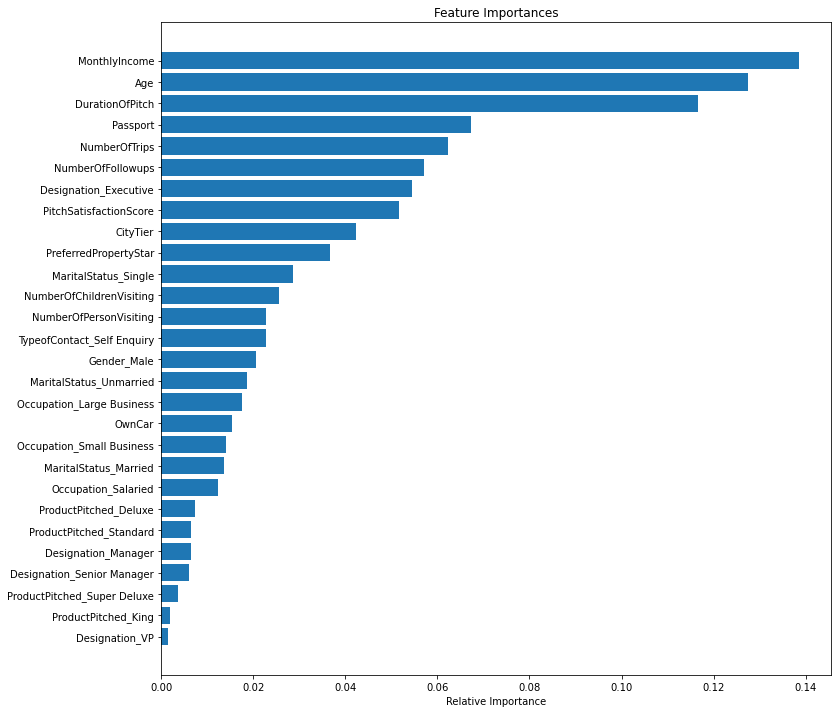

In [102]:
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("HRF", model, metrics, "Hyp-Tunned Random Forest")

### Model comparison

**Comparing Bagging Classifiers:**

,accuracy,precission,recall,specifity,f1
label,,,,,
Default Bagging,0.910020,0.608696,0.875,0.915294,0.717949
Hyp-Tunned Bagging Classifier,0.927744,0.670290,0.925,0.928177,0.777311


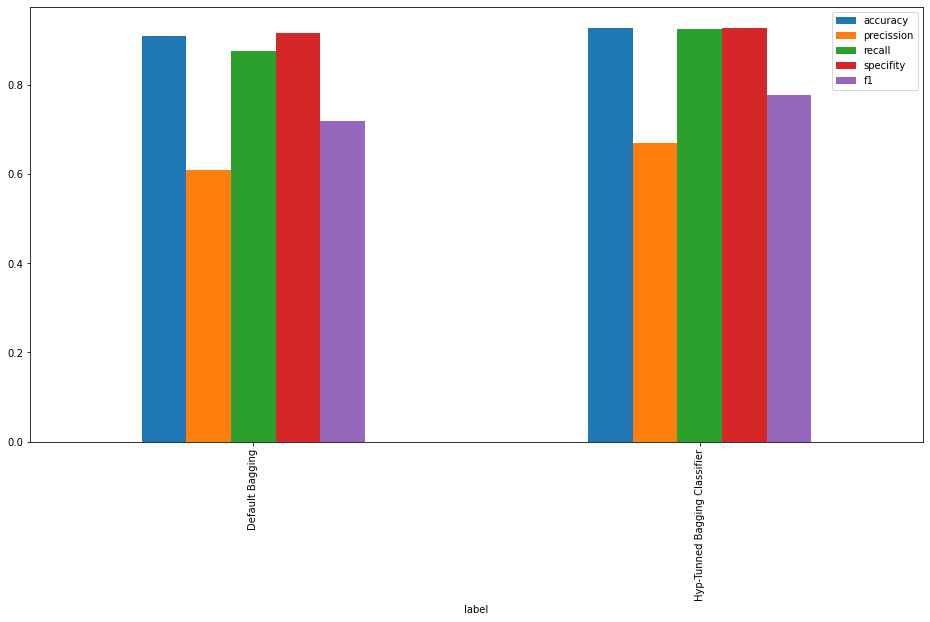

In [99]:
mc.compare(["BAG", "HBC"])

* The hyper-parameter tunned Bagging model has better perfomance than the Bagging with default parameters, related to the recall scorer on the test sample

**Comparing Random Forest Classifiers:**

,accuracy,precission,recall,specifity,f1
label,,,,,
Random Forest,0.916155,0.590580,0.942197,0.912674,0.726058
Hyp-Tunned Random Forest,0.928425,0.663043,0.938462,0.926887,0.777070


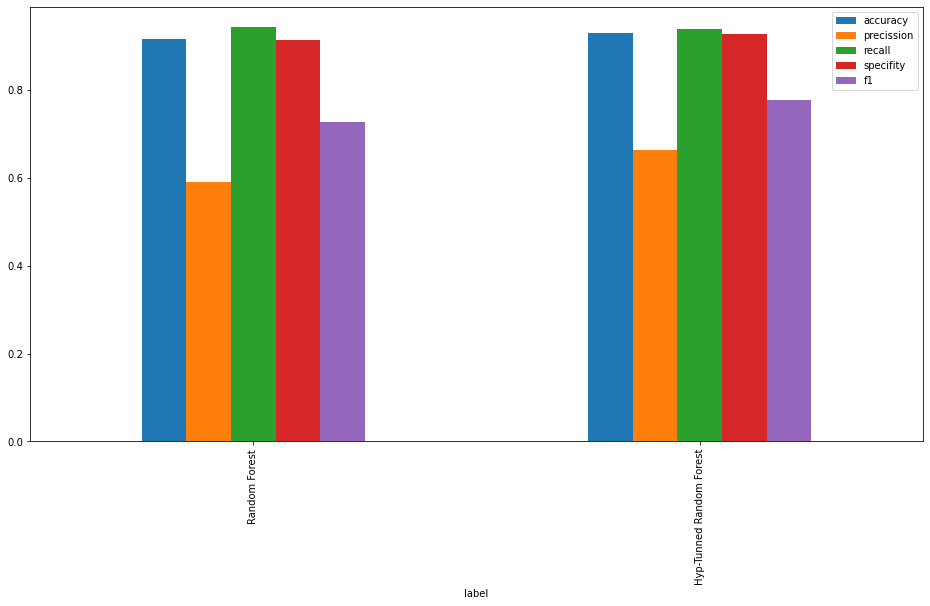

In [106]:
mc.compare(["RFC", "HRF"])

* In this case, the Random Forest Classifier with defalt parameters has better perfomance than the hyper-parameter tunned.
* The most important features are the same for both models

**Comparison of hypter-parameter tunned bagging algorithms:**

,accuracy,precission,recall,specifity,f1
label,,,,,
Hyp-Tunned Bagging Classifier,0.927744,0.670290,0.925000,0.928177,0.777311
Hyp-Tunned Random Forest,0.928425,0.663043,0.938462,0.926887,0.777070


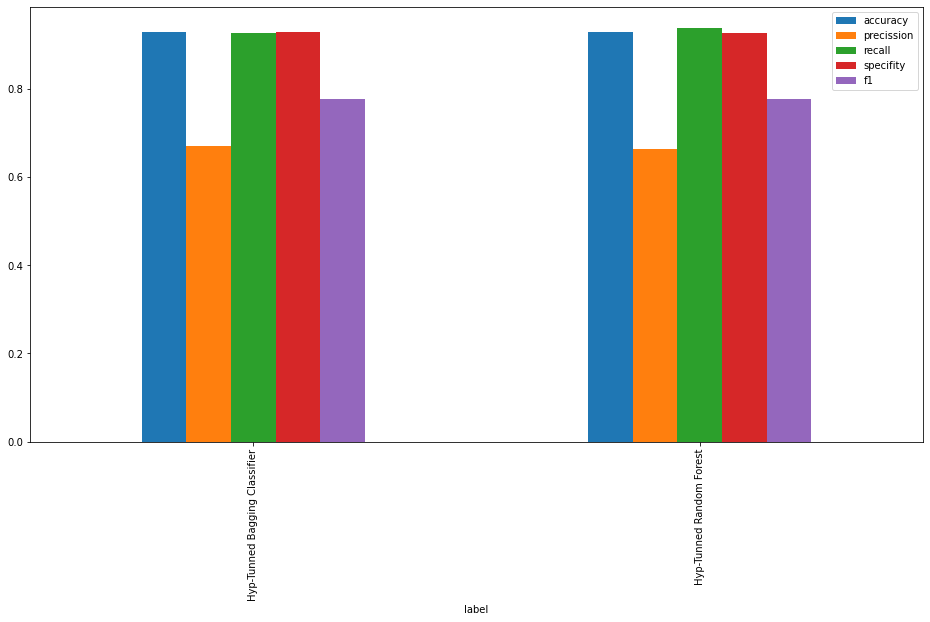

In [107]:
mc.compare(["HBC", "HRF"])

They have almost similar performance, with little advantage for the Random Forest Classifier.

**Conclusion:**

* Hyper-parameter tuned bagging models, with the range of parameters used did not improve the performance related to the Randon Forest Classifier with default parameters.
* The worse performance of the hyper-parameter tunned algorithms might be related with the choosing of range parameters for tunning
* The most important features are Montly Income, Age, and Duration of Pitch.

## Modelling: Boosting

In this section Boosting algorithms are evaluated to try to improve the prediction performance.

* AdaBoost Classifier
* Gradient Boosting Classifier
* Gradient Boosting with AdaBoost as initial estimator
* eXtreme Gradient Boosting Classifier

### AdaBoost Classifier

accuracy  : 0.85
precission: 0.326
recall    : 0.726
specifity : 0.862
f1        : 0.45


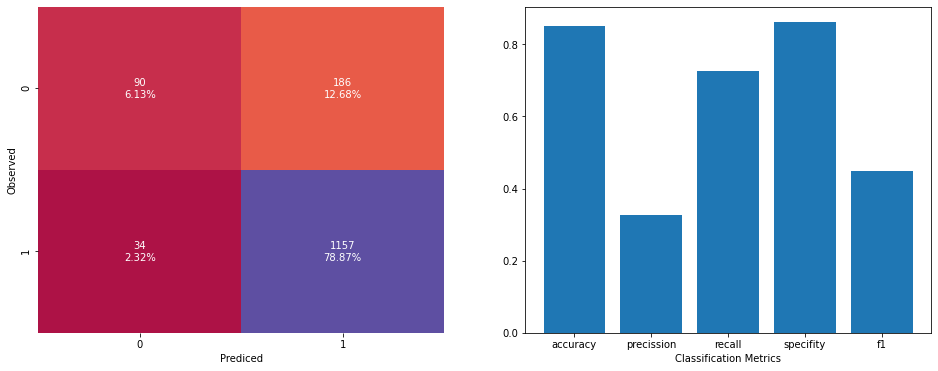

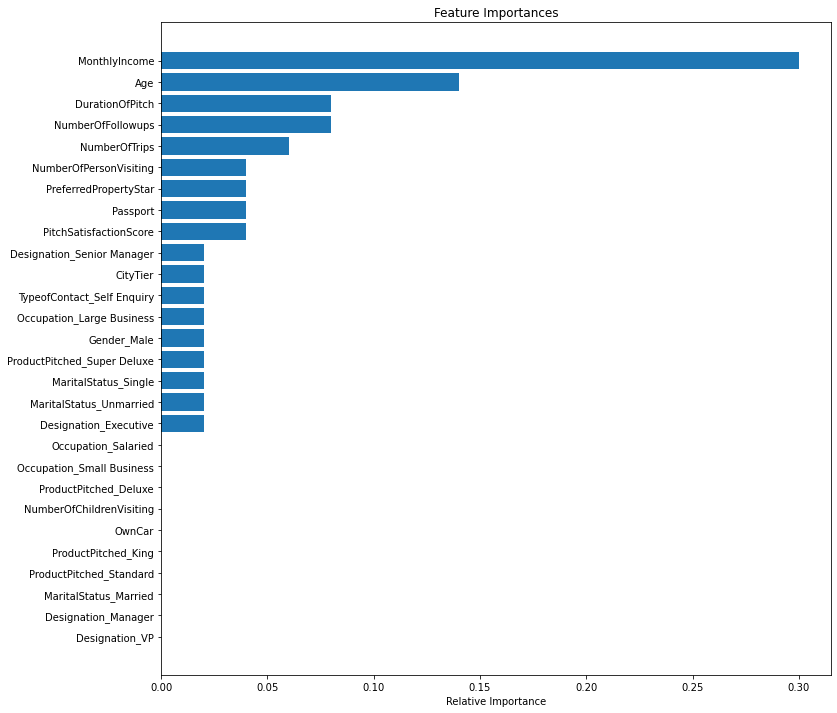

In [108]:
model = AdaBoostClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("ADA", model, metrics, "AdaBoost Classifier")

### Gradient Boosting Classifier

accuracy  : 0.868
precission: 0.402
recall    : 0.799
specifity : 0.876
f1        : 0.535


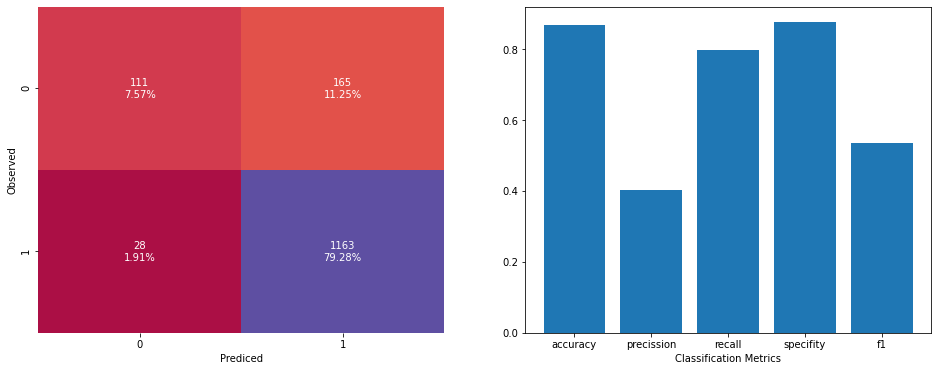

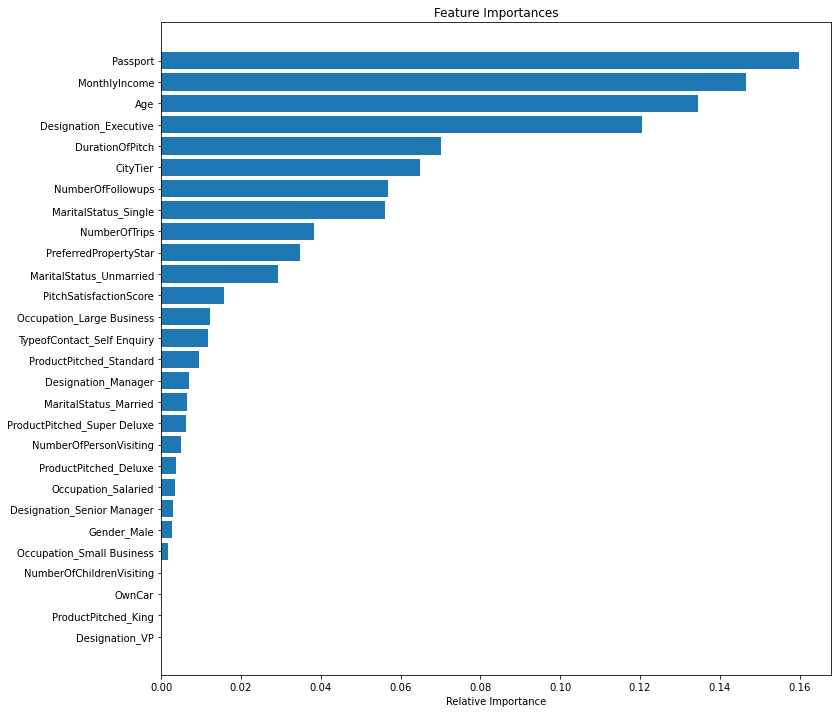

In [109]:
model = GradientBoostingClassifier(random_state=1)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("GBC", model, metrics, "Gradient Boosting")

### Gradient Boost with AdaBoosting as initial estimator

accuracy  : 0.866
precission: 0.384
recall    : 0.797
specifity : 0.873
f1        : 0.518


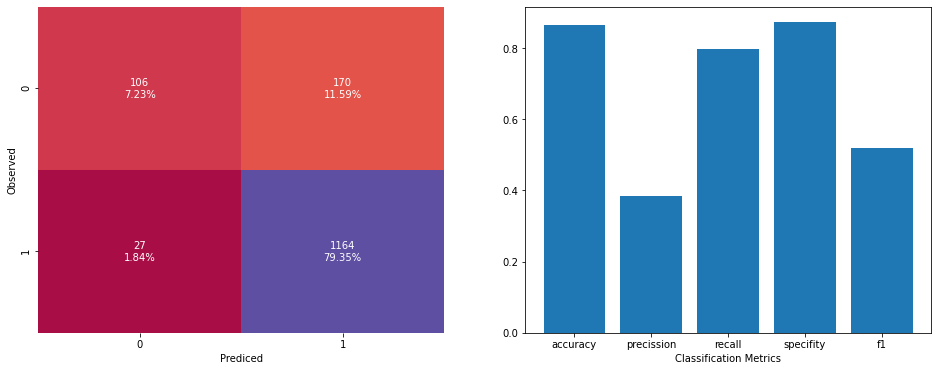

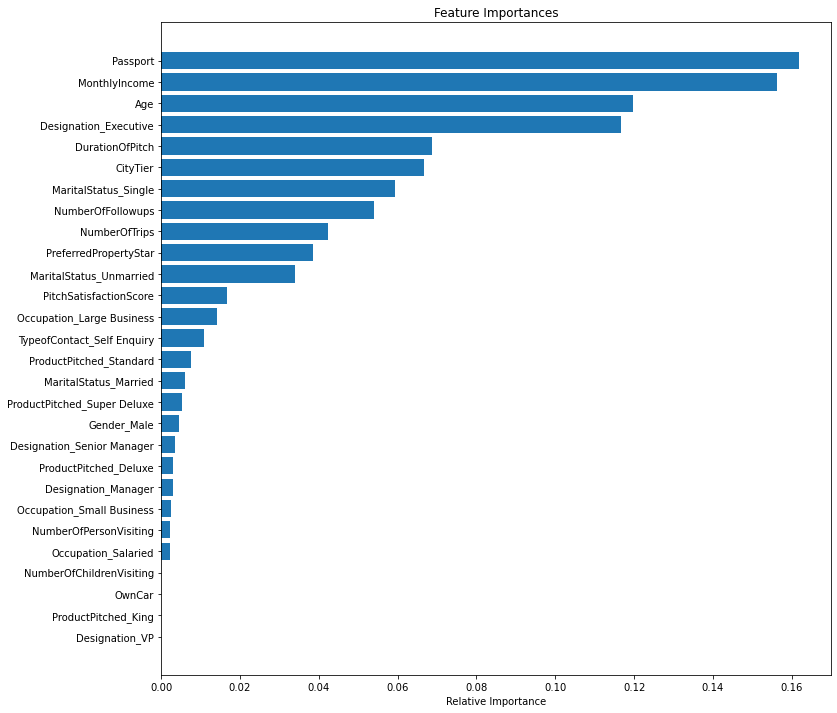

In [110]:
model = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=SEED), random_state=SEED)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("GBADA", model, metrics, "GradientBoost with init/AdaBoosting")

### XGBoost Classifier

accuracy  : 0.926
precission: 0.692
recall    : 0.893
specifity : 0.932
f1        : 0.78


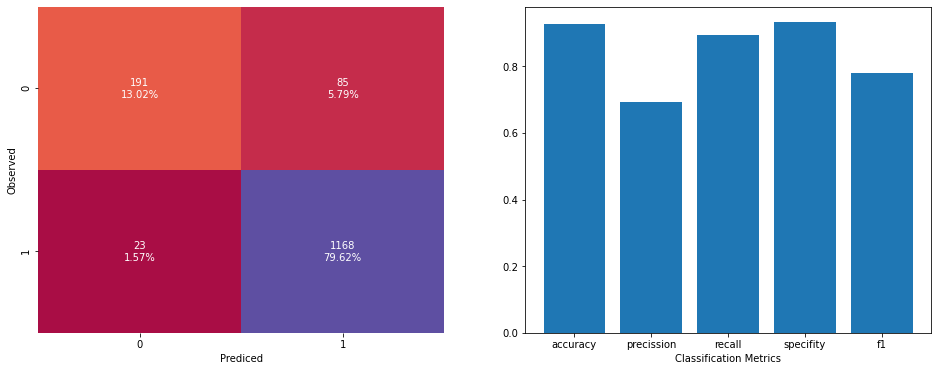

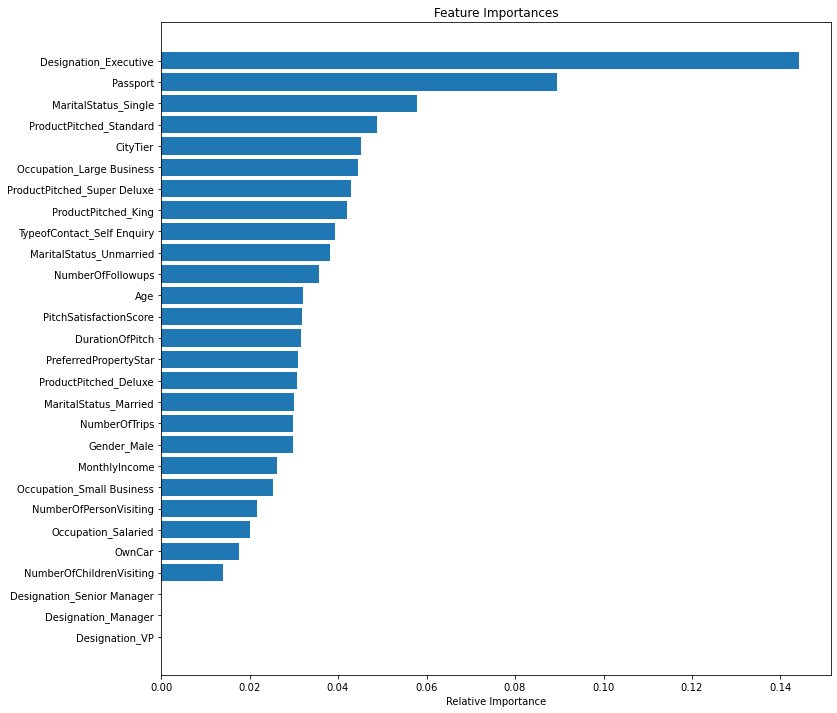

In [111]:
model = XGBClassifier(random_state=SEED, eval_metric='logloss')
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("XGB", model, metrics, "XGBoost")

### Model comparison

,accuracy,precission,recall,specifity,f1
label,,,,,
AdaBoost Classifier,0.850034,0.326087,0.725806,0.861504,0.450000
Gradient Boosting,0.868439,0.402174,0.798561,0.875753,0.534940
GradientBoost with init/AdaBoosting,0.865712,0.384058,0.796992,0.872564,0.518337
XGBoost,0.926380,0.692029,0.892523,0.932163,0.779592


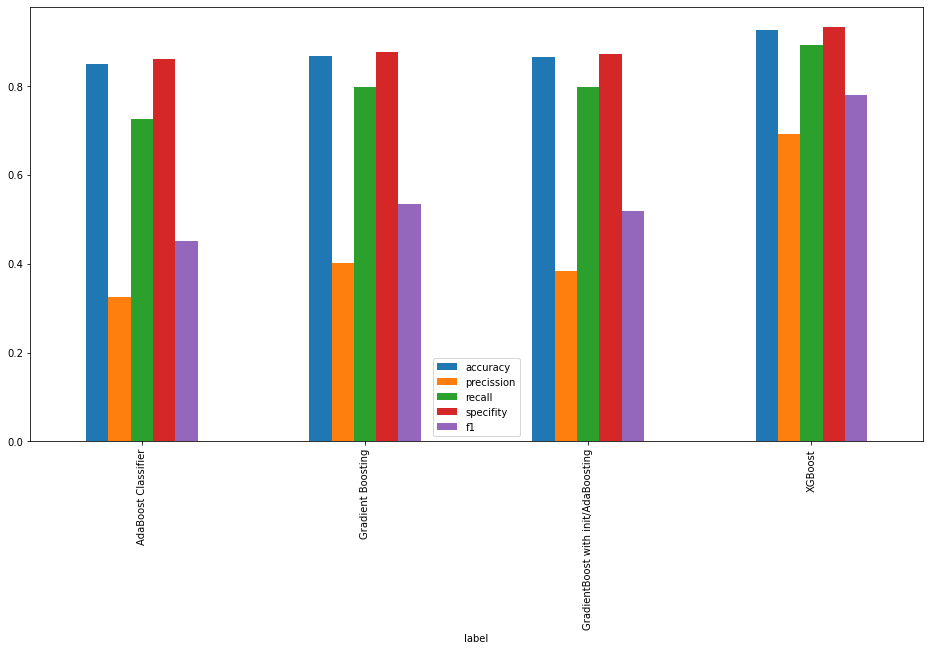

In [113]:
mc.compare(["ADA", "GBC", "GBADA", "XGB"])

* In the category of boosting algorithms, related to the recall score on the test sample, the eXtreme Gradient Boosting algorithm has the best performance
* The most important features are different amonth these models. For example, for the eXtrema Gradient Boosting model, the most important features are Designation as Executive, having a passport, and being single.
* However, the bagging algorithms with default parameters have better performance than the boosting algorithms with default parameters, as it is shown in the below comparison

,accuracy,precission,recall,specifity,f1
label,,,,,
Random Forest,0.916155,0.590580,0.942197,0.912674,0.726058
XGBoost,0.926380,0.692029,0.892523,0.932163,0.779592


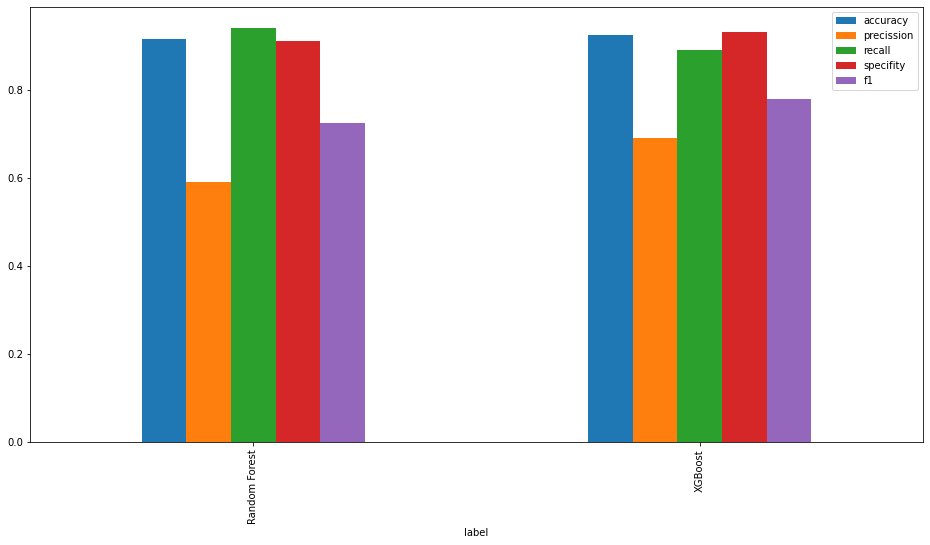

In [115]:
mc.compare(["RFC", "XGB"])

## Modelling: Boosting with Hyper-parameter tunning

In this section the presented boosting algorithms are used to generate more models with hyper-parameter tunning.

### AdaBoost

In [124]:
base_model = AdaBoostClassifier(random_state=SEED)
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=i, random_state=SEED) for i in range(20, 24)],
    "n_estimators": [10, 50, 100],
    "learning_rate":np.arange(0.1,2,0.1)
}
scorer = make_scorer(recall_score)
gs = GridSearchCV(base_model, parameters, scoring=scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
model = gs.best_estimator_
model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=22,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=10, random_state=1)

The best model has as parameters:

* Base estimator: a decision tree classifier with 22 levels 
* Number of estimators: 10
* Learning rate: 0.1

accuracy  : 0.896
precission: 0.688
recall    : 0.739
specifity : 0.929
f1        : 0.713


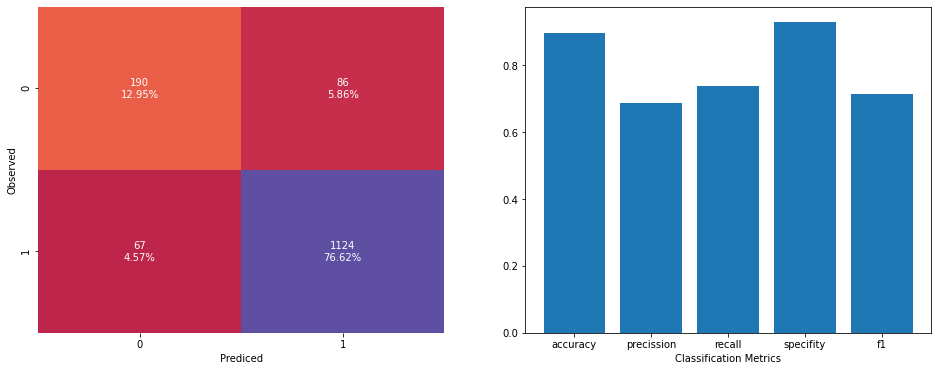

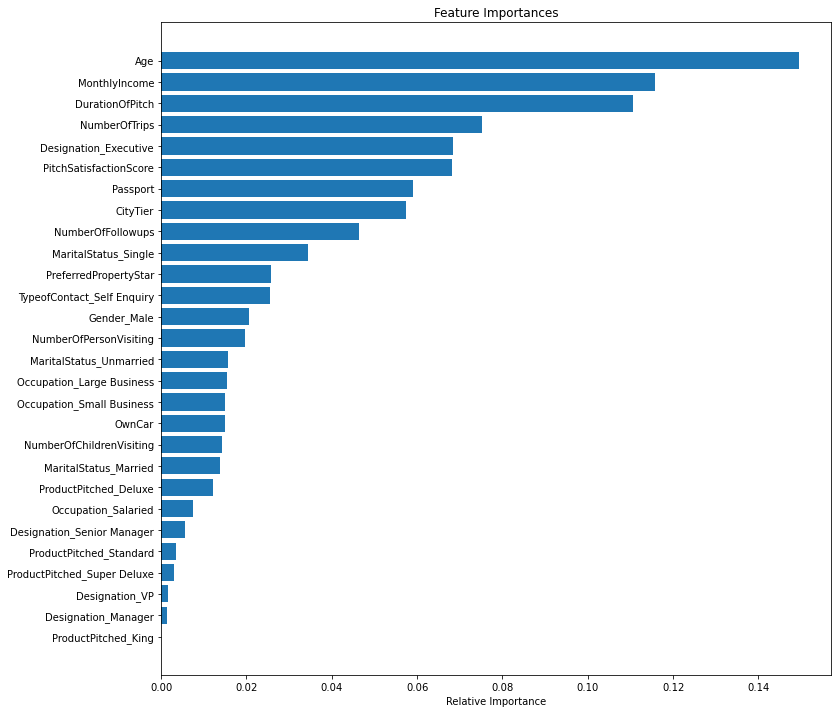

In [126]:
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("HADA", model, metrics, "Hyp-Tunned AdaBoosting")

### Gradient Boosting

In [128]:
base_model = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=SEED), random_state=SEED)
parameters = {
    "n_estimators": [10, 50, 100],
    "subsample": [0.7, 1.0],
    "learning_rate":[0.01, 0.05, 0.1, 0.2],
    "max_depth": np.arange(20, 24),
    "max_features": [0.7, 1.0],
}
scorer = make_scorer(recall_score)
gs = GridSearchCV(base_model, parameters, scoring=scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
model = gs.best_estimator_
model.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_depth=22, max_features=0.7,
                           n_estimators=10, random_state=1)

The best model has as parameters:

* Number of estimators: 10 
* Learning rate: 0.2
* Maximum depth: 22
* Maximum features: 0.7 

accuracy  : 0.937
precission: 0.768
recall    : 0.88
specifity : 0.948
f1        : 0.82


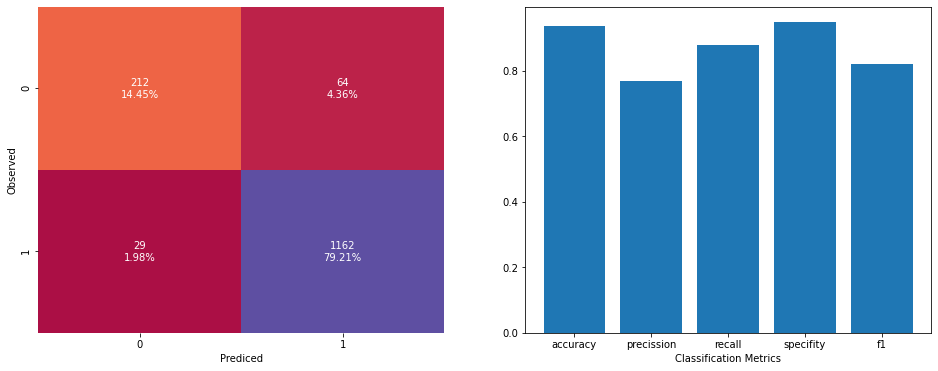

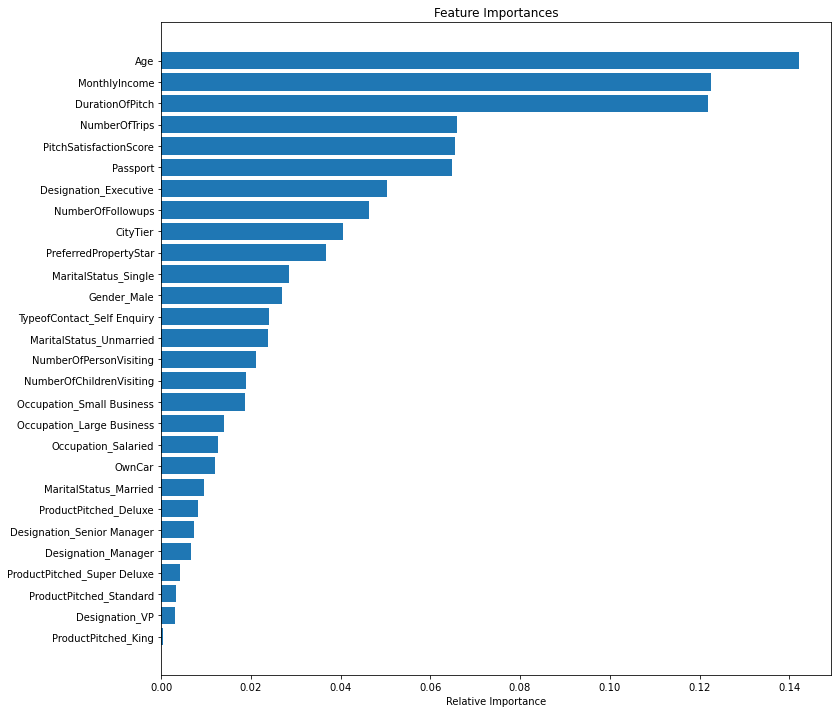

In [129]:
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("HGB", model, metrics, "Hyp-Tunned GradientBoost")

### XGBoosting

In [130]:
base_model = XGBClassifier(random_state=SEED, eval_metric='logloss')
parameters = {
    "n_estimators": [10, 50, 100],
    "scale_pos_weight": [0, 1, 2],
    "subsample": [0.7, 1.0],
    "learning_rate":[0.01, 0.05, 0.1],
    "gamma": np.arange(0, 3),
    "colsample_bytree": [0.7, 1.0],
    "colsample_bylevel": [0.7, 1.0],
}
scorer = make_scorer(recall_score)
gs = GridSearchCV(base_model, parameters, scoring=scorer, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
model = gs.best_estimator_
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

The best model has as parameters:

* Number of estimators: 100
* Gamma: 0
* Learning rate: 0.1
* Maximum depth: 6

accuracy  : 0.917
precission: 0.699
recall    : 0.832
specifity : 0.933
f1        : 0.76


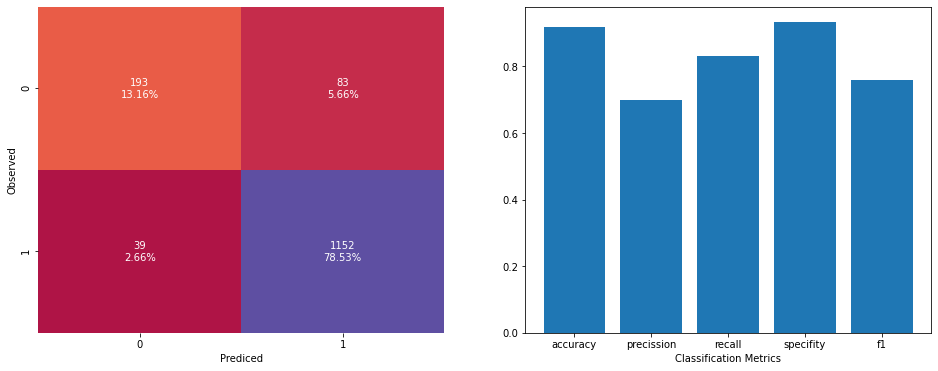

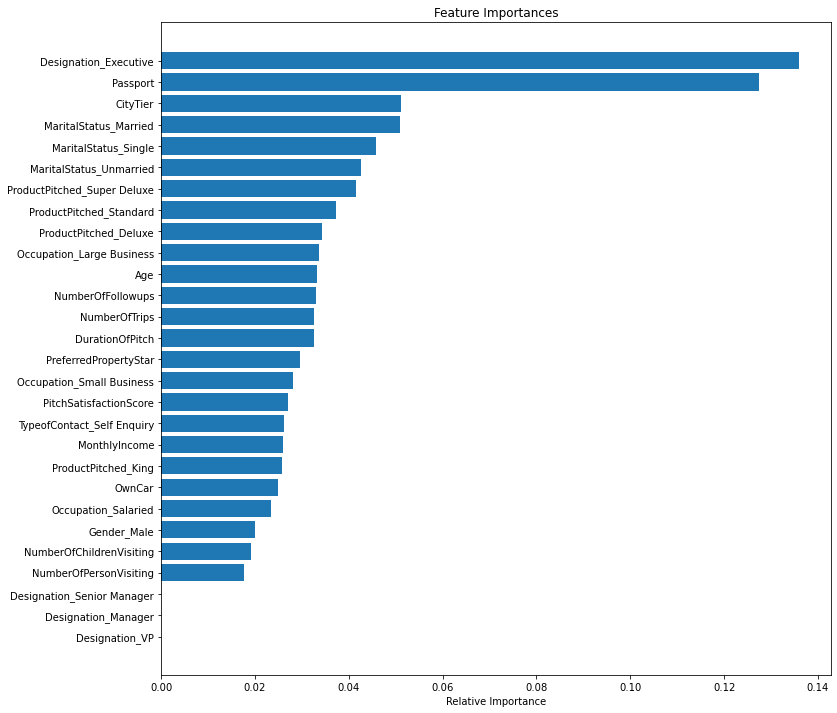

In [131]:
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

mc.append("HXBG", model, metrics, "Hyp-Tunned XGBoost")

### Model comparison

,accuracy,precission,recall,specifity,f1
label,,,,,
Hyp-Tunned AdaBoosting,0.895706,0.688406,0.739300,0.928926,0.712946
Hyp-Tunned GradientBoost,0.936605,0.768116,0.879668,0.947798,0.820116
Hyp-Tunned XGBoost,0.916837,0.699275,0.831897,0.932794,0.759843


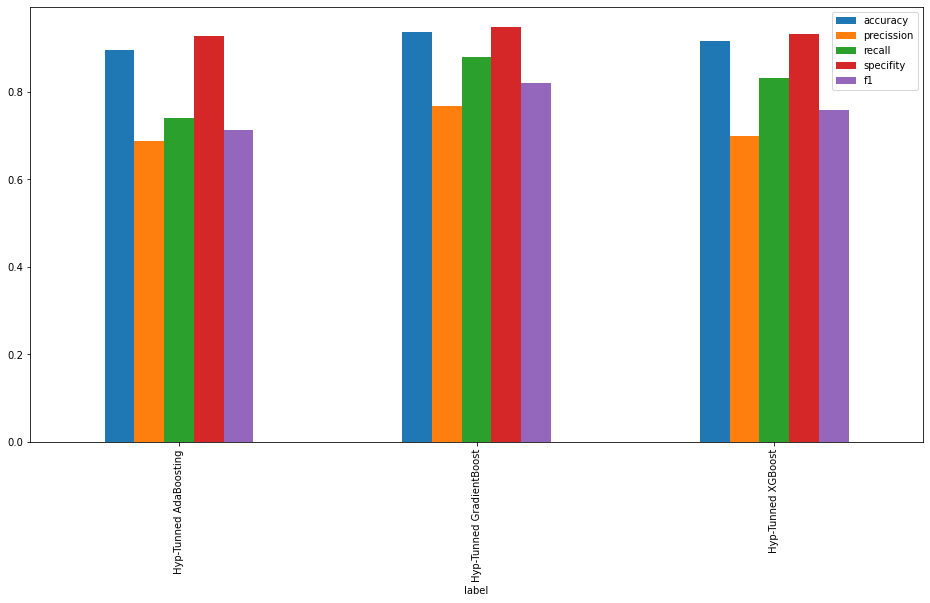

In [132]:
mc.compare(["HADA", "HGB", "HXBG"])

* With hyper-parameter tunning, the best boosting algorithm with recall score on the test dataset was the Gradient Boosting Classifier
* Maybe the worse performance is due the selection of ranges for parameters evaluated
* Comparing all methods, Random Forest Classifier with default parameters has the better performance in this analysis, as is shown in the below visualization

,accuracy,precission,recall,specifity,f1
label,,,,,
Random Forest,0.916155,0.590580,0.942197,0.912674,0.726058
Hyp-Tunned Random Forest,0.928425,0.663043,0.938462,0.926887,0.777070
XGBoost,0.926380,0.692029,0.892523,0.932163,0.779592
Hyp-Tunned GradientBoost,0.936605,0.768116,0.879668,0.947798,0.820116


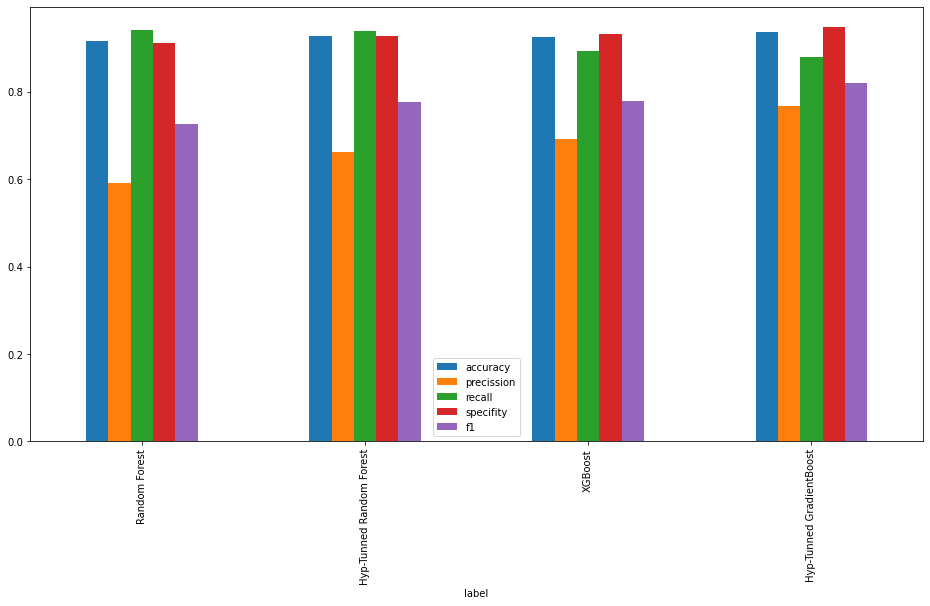

In [134]:
mc.compare(["RFC", "HRF", "XGB", "HGB"])

## Actionable Insights & Recommendations

Results for the Random Forest Classifier are shown again.

accuracy  : 0.916
precission: 0.591
recall    : 0.942
specifity : 0.913
f1        : 0.726


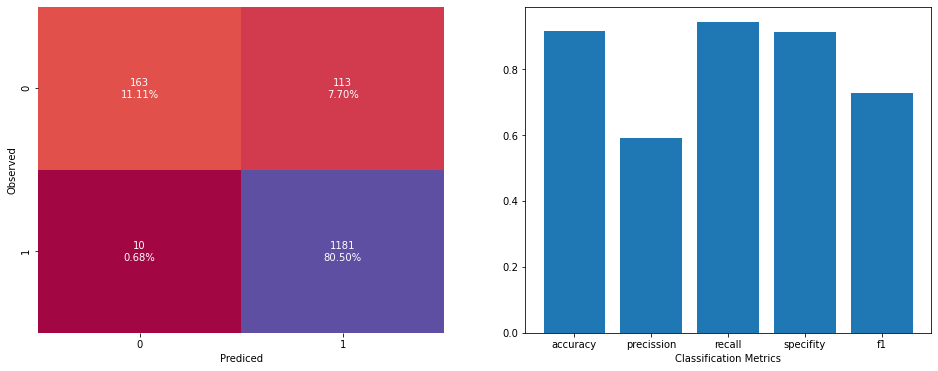

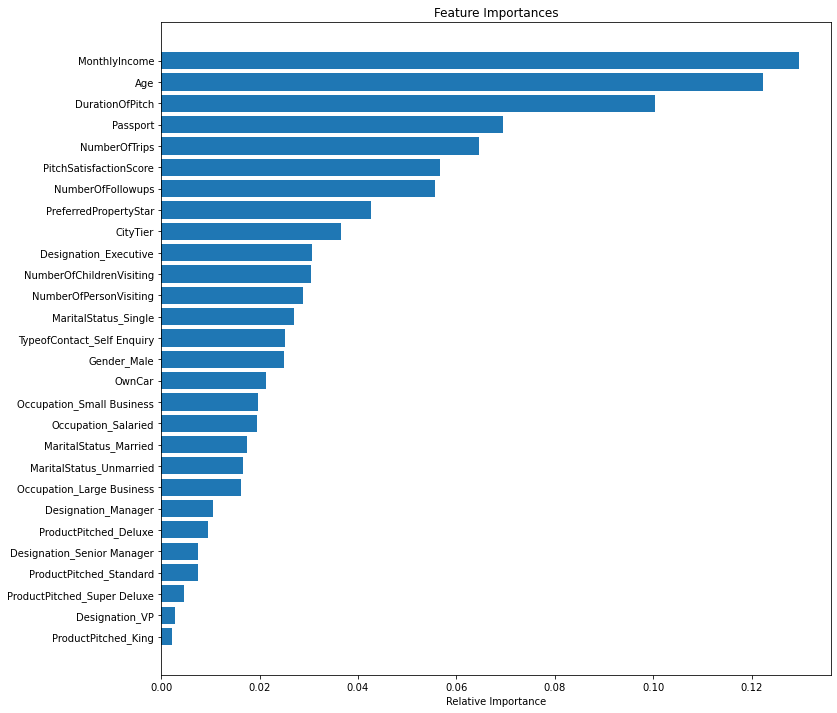

In [142]:
rf = [m for m in mc.metrics_collection if m['code'] == "RFC"][0]
model = rf["model"]
y_hat = model.predict(X_test)
metrics = computeMetrics(y_test, y_hat)
showMetrics(metrics)
featureImportance(model, X_train.columns)

Based on the previous analysis, these are some key insights:
    
* The decision of a customer to take the product may be predicted up to 0.94 for a recall score
* The most importan features are Monthly Income, Age, and Duration of Pitch
* The company can have up to 7.7% of false positive, but it is a reasonable margin
* The company can reach up to 11.78% of customer to take the product, including false negative customers

Recommendations:

* Adopt this model for predictions
* Design the campaing to reach customers based on their income and age
* Priotize the duration of the pitch to get success on sales